<a href="https://colab.research.google.com/github/martinfernandoortiz/worldCloud_Geografia/blob/main/wordCloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# World Cloud - IV Congreso Nacional de Geografía de Universidades Públicas

Se generó una nueve de palabras a partir de la última circular del Congreso Nacional de Geografía de Universidades Públicas. El trabajo se divide en los siguientes pasos:
- pasar el pdf a texto
- limpiar el texto con las palabras que no queremos
- generación de imagen
- agregado de stopwords


## pasar el pdf a texto

In [2]:
#pip install PyPDF2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 2.7 MB/s eta 0:00:00


In [112]:
# importing required modules
from PyPDF2 import PdfReader
from PIL import Image
from io import BytesIO
from wordcloud import WordCloud
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import zipfile
import plotly.express as px
import plotly.graph_objects as go
import colorsys

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
reader = PdfReader('/content/drive/MyDrive/datasets_colab/congresoPROGRAMA.pdf')

In [28]:
# printing number of pages in pdf file
print(len(reader.pages))
largo = len(reader.pages)
text = ""

43


In [30]:
for x in range(0, largo):


# getting a specific page from the pdf file
  page = reader.pages[x]
# extracting text from page
  text = text + page.extract_text()




## Generación de la nube de palabras sin filtrar

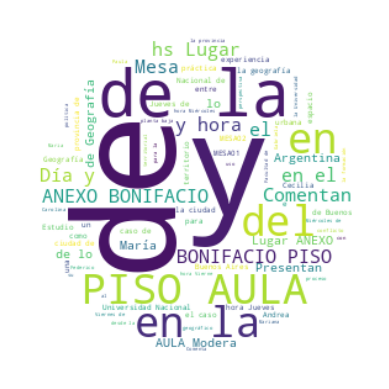

In [33]:
x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)


wc = WordCloud(background_color="white", repeat=True, mask=mask)
wc.generate(text)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

In [43]:
#Grabar en un archivo para limpiar
with open('/content/drive/MyDrive/datasets_colab/sample1.txt', 'w') as f:
    f.write(text)

Se crea un dataframe de una columna para poder ver más facil los patrones de texto que hay que eliminar

In [ ]:
import pandas as pd
lines = text.splitlines()

# Crear un DataFrame con una columna llamada 'texto'
df = pd.DataFrame({'texto': lines})

# Quitar espacios en blanco al principio y al final de cada registro
#df['texto'] = df['texto'].str.strip()

# Ordenar el DataFrame alfabéticamente por la columna 'texto'
df = df.sort_values(by='texto')

# Mostrar el DataFrame
#print(df)

# Guardar el DataFrame en un archivo Excel
df.to_excel('/content/drive/MyDrive/datasets_colab/output.xlsx', index=False)


Se genero un texto que va a tener los patrones a reemplazar. Esto se hizo de forma manual y se puede ver en el archivo quitar.txt

In [ ]:
#text = "..."  # Reemplaza "..." con tu cadena de texto
#quitar_filename = 'quitar.txt'

with open('/content/drive/MyDrive/datasets_colab/quitar.txt', 'r') as file:
    lines_to_remove = file.readlines()


# Elimina los espacios en blanco al principio y al final de cada línea y convierte a conjunto para manejar duplicados
lines_to_remove = set(line.strip() for line in lines_to_remove)

# Aplica el reemplazo en 'text' para cada línea en 'lines_to_remove'
for line_to_remove in lines_to_remove:
    text = text.replace(line_to_remove.strip(), '')

# Muestra el resultado
print(text)

# Si deseas guardar el resultado en un nuevo archivo 'text_filtered.txt'
with open('text_filtered.txt', 'w') as file:
    file.write(text)

## Nube de palabras

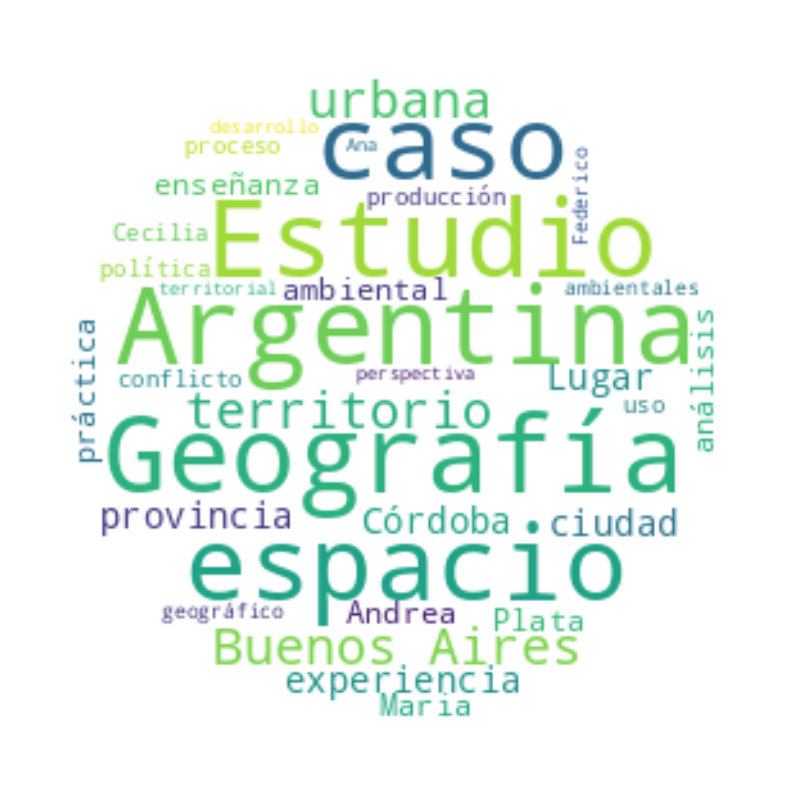

In [119]:
#Forma de Circulo
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)


wc = WordCloud(height = 300, width = 300, background_color="white", repeat=True,
               mask=mask,
               max_font_size = 42, min_font_size = 6,
               #colormap = "magma",
               #max_words = 3,
               #contour_width = .1, contour_color = "grey",
               stopwords = ["de", "Día", "hora", "lo", "Anexo", "Bonifacio", "del", "en", "la", "el", "Universidad", "Nacional",
                            "las","para","a","Comentan","Moderan","entre","Facultad","Jueves","Miércoles","los","Mesa","Aula","I","II","como","estrategia","su","Instituto",
                            "e","al","y","una","desde","un","María","h","con","sobre","hs","Modera","Presenta"])
wc.generate(text)


plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()


## Nube de Palabras - Argentina

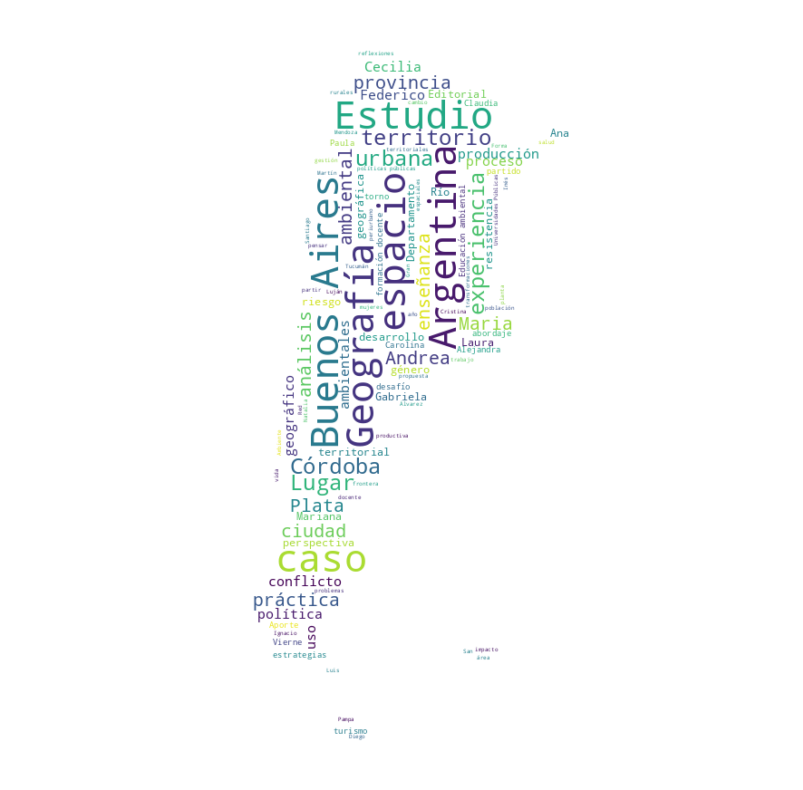

In [110]:
#Forma Imagen
mask = np.array(Image.open("/content/drive/MyDrive/datasets_colab/argentina.jpg"))

wc = WordCloud(height = 300, width = 300, background_color="white", repeat=True,
               mask=mask,
               max_font_size = 42, min_font_size = 6,
               #colormap = "magma",
               #max_words = 3,
               #contour_width = .1, contour_color = "grey",
               stopwords = ["de", "Día", "hora", "lo", "Anexo", "Bonifacio", "del", "en", "la", "el", "Universidad", "Nacional",
                            "las","para","a","Comentan","Moderan","entre","Facultad","Jueves","Miércoles","los","Mesa","Aula","I","II","como","estrategia","su","Instituto",
                            "e","al","y","una","desde","un","María","h","con","sobre","hs","Modera","Presenta"])
wc.generate(text)


plt.figure(figsize=(20, 10))


plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()


Vamos a ver si podemos filtrar los nombres a partir del listado histórico de Nombres de Argentina

## Filtro de palabras no deseadas

- Vamos a generar una variable llamada stopwords para eliminar pronombres y palabras que no hacen al análisis
- Vamos a utilizar un dataset con los nombres más frecuentes de argentina para borrar los nombres de los autores de la nube.

In [144]:
stopwords_total = ["de", "Día", "hora", "lo", "Anexo", "Bonifacio", "del", "en", "la", "el", "Universidad", "Nacional",
                            "las","para","a","Comentan","Moderan","entre","Facultad","Jueves","Miércoles","los","Mesa","Aula","I","II","como","estrategia","su","Instituto",
                            "e","al","y","una","desde","un","María","h","con","sobre","hs","Modera","Presenta","por","café"]



In [ ]:
# URL del archivo ZIP
url = "https://infra.datos.gob.ar/catalog/otros/dataset/2/distribution/2.1/download/historico-nombres.zip"

# Descargar y descomprimir el archivo ZIP
response = requests.get(url)
with zipfile.ZipFile(BytesIO(response.content), 'r') as zip_ref:
    zip_ref.extractall()

# Listar los archivos descomprimidos (para verificar el nombre del archivo CSV)
file_names = zip_ref.namelist()

# Elegir el nombre del archivo CSV (puede variar)
csv_file_name = [name for name in file_names if name.endswith('.csv')][0]

# Cargar el archivo CSV con pandas
df = pd.read_csv(csv_file_name)

In [115]:
# Limpiar la columna 'nombre' (extraer la primera palabra)
df['nombre'] = df['nombre'].apply(lambda x: re.split(r'\s+', str(x))[0])

# Obtener una lista de nombres únicos
unique_names = df['nombre'].drop_duplicates().tolist()

# Mostrar la lista de nombres únicos
#print(unique_names)

['Maria', 'Rosa', 'Jose', 'Carmen', 'Ana', 'Juana', 'Antonio', 'Elena', 'Teresa', 'Angela', 'Margarita', 'Catalina', 'Francisco', 'Juan', 'Francisca', 'Elvira', 'Josefa', 'Nelida', 'Luisa', 'Antonia', 'Isabel', 'Pedro', 'Lucia', 'Sara', 'Victoria', 'Amalia', 'Luis', 'Manuel', 'Mercedes', 'Julia', 'Aurora', 'Elsa', 'Carlos', 'Miguel', 'Emilia', 'Concepcion', 'Vicente', 'Alberto', 'Matilde', 'Amelia', 'Josefina', 'Enrique', 'Domingo', 'Dolores', 'Irma', 'Dora', 'Adela', 'Elisa', 'Dominga', 'Ramona', 'Delia', 'Magdalena', 'Aida', 'Nicolas', 'Haydee', 'Roberto', 'Angel', 'Alfredo', 'José', 'Manuela', 'Zulema', 'Lidia', 'Clara', 'Rosario', 'Raquel', 'Ricardo', 'Ernesto', 'Alicia', 'Petrona', 'Emma', 'Gregoria', 'Irene', 'Celia', 'Eduardo', 'Paulina', 'Pilar', 'Carmela', 'Felisa', 'Filomena', 'Armando', 'Leonor', 'Felipe', 'Esther', 'Adelina', 'Rosalia', 'Gregorio', 'Salvador', 'Beatriz', 'Eugenia', 'Guillermo', 'Juliana', 'Emilio', 'Rafael', 'Sofia', 'Herminia', 'Mario', 'Raul', 'Oscar', 'A

Generamos un listado de stopwords con los que había antes y los nombres

In [ ]:
#Generamos un listado con las palabras que no suman y los nombres
stopwords_total.extend(unique_names)

## Nube de Palabras Filtrada - Argentina

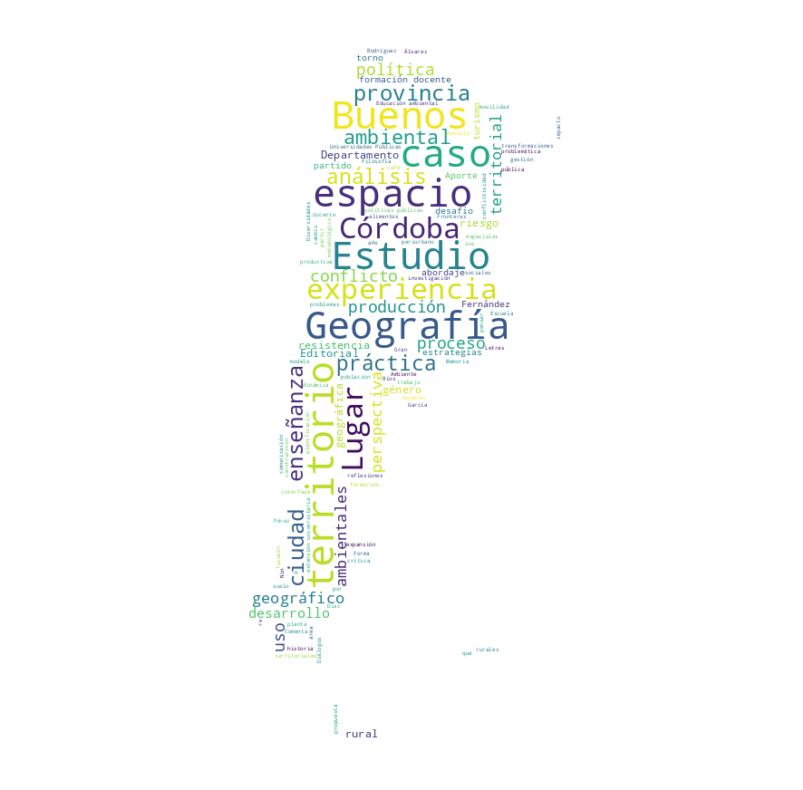

In [118]:
#Forma Imagen
mask = np.array(Image.open("/content/drive/MyDrive/datasets_colab/argentina.jpg"))

wc = WordCloud(height = 300, width = 300, background_color="white", repeat=True,
               mask=mask,
               max_font_size = 42, min_font_size = 6,
               #colormap = "magma",
               #max_words = 3,
               #contour_width = .1, contour_color = "grey",
               stopwords = stopwords_total)
wc.generate(text)


plt.figure(figsize=(20, 10))


plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()


<ipython-input-150-e1c463f34ad1>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap("viridis")  # Puedes cambiar "viridis" por cualquier mapa de color de matplotlib
<ipython-input-150-e1c463f34ad1>:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Scales")  # Puedes cambiar el label según lo que representa la escala


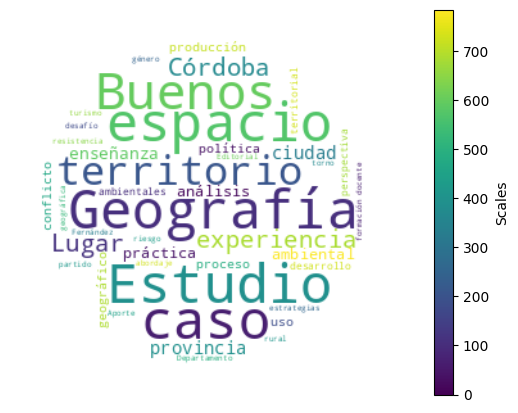

In [150]:
#Forma de Circulo
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)


wc = WordCloud(height = 300, width = 300, background_color="white", repeat=True,
               mask=mask,
               max_font_size = 42, min_font_size = 6,
               #relative_scaling=0.5,
               #colormap = "magma",
               #max_words = 3,
               #contour_width = .1, contour_color = "grey",
               stopwords = stopwords_total)
wc.generate(text)


# Configura la barra de color
colormap = plt.cm.get_cmap("viridis")  # Puedes cambiar "viridis" por cualquier mapa de color de matplotlib
norm = plt.Normalize(vmin=0, vmax=784)  # Ajusta los valores mínimos y máximos según tu escala
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])

# Muestra la WordCloud con matplotlib y agrega la barra de color
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.colorbar(sm, label="Scales")  # Puedes cambiar el label según lo que representa la escala
plt.axis('off')
plt.show()






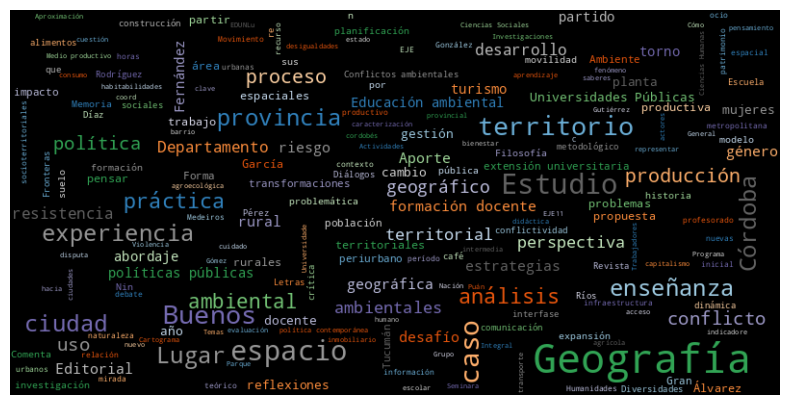

In [140]:
wordcloud = WordCloud(width=800, height=400, relative_scaling=0.5,
                      background_color="black",
               max_font_size = 42, min_font_size = 6,
               colormap = "tab20c",
               #max_words = 3,
               #contour_width = .1, contour_color = "grey",
               stopwords = stopwords_total).generate(text)

# Muestra la WordCloud con matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

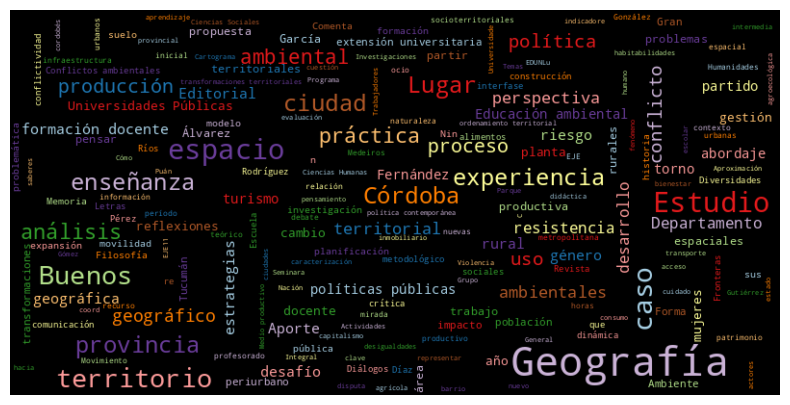

In [165]:


wordcloud = WordCloud(width=800, height=400, relative_scaling=0.5,
                      background_color="black",
               max_font_size = 42, min_font_size = 6,
               #colormap = "rainbow",
               #colormap = "Set2",
              colormap = "Paired",


               #max_words = 20,
               #contour_width = .1, contour_color = "grey",
               stopwords = stopwords_total).generate(text)

# Muestra la WordCloud con matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [222]:
import plotly.express as px

# Configura la WordCloud con el tamaño deseado y fondo oscuro
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Paired', stopwords=stopwords_total)

# Genera las frecuencias de palabras
word_frequencies = wordcloud.process_text(text)

# Crea un DataFrame con las frecuencias de palabras
df_word_frequencies = pd.DataFrame(list(word_frequencies.items()), columns=['Word', 'Frecuencia'])

# Ordena el DataFrame de forma descendente por frecuencia
df_word_frequencies = df_word_frequencies.sort_values(by='Frecuencia', ascending=False)

# Toma solo las 50 palabras más repetidas
df_top_50 = df_word_frequencies.head(30)

# Crea la figura interactiva con Plotly Express y ajusta el eje x
fig = px.bar(df_top_50, x='Word', y='Frecuencia', title='50 Palabras Más repetidas', labels={'Frecuencia': 'Frecuencia'},
             color='Word'
             , color_discrete_sequence=['lightgoldenrodyellow'])

fig.update_xaxes(tickangle=-90)

# Ajusta el fondo y el color del texto y etiquetas
fig.update_layout(
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='#ffff99'),  # Color del texto
    xaxis=dict(tickfont=dict(color='#b2df8a')),  # Color de las etiquetas del eje x
    hoverlabel=dict(bgcolor='#ff7f00'),  # Fondo del tooltip
    hovermode="x"
)

# Muestra la figura interactiva
fig.show()

In [ ]:
https://datos.gob.ar/dataset/renaper-distribucion-apellidos-argentina/archivo/renaper_2.3

<ipython-input-242-ee85afc2db55>:44: UserWarning:

FixedFormatter should only be used together with FixedLocator



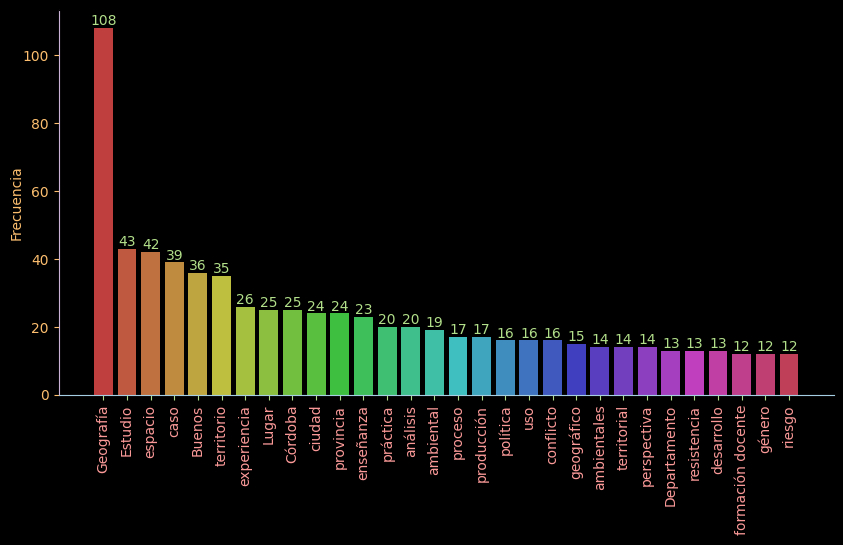

In [242]:

# Configura la WordCloud con el tamaño deseado y fondo oscuro
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Paired', stopwords=stopwords_total)

# Genera las frecuencias de palabras
word_frequencies = wordcloud.process_text(text)

# Crea un DataFrame con las frecuencias de palabras
df_word_frequencies = pd.DataFrame(list(word_frequencies.items()), columns=['Word', 'Frecuencia'])

# Ordena el DataFrame de forma descendente por frecuencia
df_word_frequencies = df_word_frequencies.sort_values(by='Frecuencia', ascending=False)

# Toma solo las 30 palabras más repetidas
df_top_30 = df_word_frequencies.head(30)

# Obtén colores de la WordCloud utilizando el modelo de color HSL
hsl_colors = [(i / len(df_top_30), 0.5, 0.5) for i in range(len(df_top_30))]

# Convierte colores HSL a RGB
rgb_colors = [colorsys.hls_to_rgb(h, l, s) for (h, l, s) in hsl_colors]

# Convierte valores RGB a formato hexadecimal
hex_colors = ['#%02x%02x%02x' % (int(r * 255), int(g * 255), int(b * 255)) for (r, g, b) in rgb_colors]

# Crea un gráfico de barras con Matplotlib
fig, ax = plt.subplots(figsize=(10, 5), facecolor='black')  # Fondo negro de la figura
bars = ax.bar(df_top_30['Word'], df_top_30['Frecuencia'], color=hex_colors)

# Agrega etiquetas con el número en cada barra sin decimales
for bar, label in zip(bars, df_top_30['Frecuencia']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{int(label)}', ha='center', va='bottom', color='#b2df8a')

# Ajusta el fondo y el color del texto y etiquetas
ax.set_facecolor('black')
ax.tick_params(axis='x', colors='#b2df8a')
ax.tick_params(axis='y', colors='#fdbf6f')
ax.spines['bottom'].set_color('#a6cee3')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('#cab2d6')

# Etiquetas del eje x rotadas -90 grados
ax.set_xticklabels(df_top_30['Word'], rotation=90, ha='center', color='#fb9a99')

# Etiqueta del eje y rotada 90 grados
ax.set_ylabel('Frecuencia', rotation=90, va='center', color='#fdbf6f')

# Muestra el gráfico
plt.show()

<ipython-input-246-ce05ab140b88>:38: UserWarning:

FixedFormatter should only be used together with FixedLocator



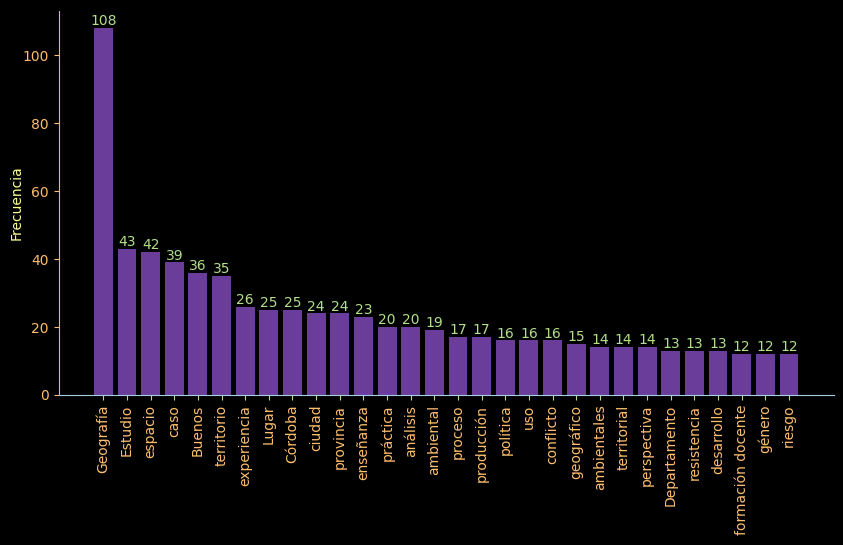

In [246]:

# Configura la WordCloud con el tamaño deseado y fondo oscuro
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Paired', stopwords=stopwords_total)

# Genera las frecuencias de palabras
word_frequencies = wordcloud.process_text(text)

# Crea un DataFrame con las frecuencias de palabras
df_word_frequencies = pd.DataFrame(list(word_frequencies.items()), columns=['Word', 'Frecuencia'])

# Ordena el DataFrame de forma descendente por frecuencia
df_word_frequencies = df_word_frequencies.sort_values(by='Frecuencia', ascending=False)

# Toma solo las 30 palabras más repetidas
df_top_30 = df_word_frequencies.head(30)

# Configura un color específico para todas las barras
bar_color = '#6a3d9a'

# Crea un gráfico de barras con Matplotlib
fig, ax = plt.subplots(figsize=(10, 5), facecolor='black')  # Fondo negro de la figura
bars = ax.bar(df_top_30['Word'], df_top_30['Frecuencia'], color=bar_color)

# Agrega etiquetas con el número en cada barra sin decimales
for bar, label in zip(bars, df_top_30['Frecuencia']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{int(label)}', ha='center', va='bottom', color='#b2df8a')

# Ajusta el fondo y el color del texto y etiquetas
ax.set_facecolor('black')
ax.tick_params(axis='x', colors='#b2df8a')
ax.tick_params(axis='y', colors='#fdbf6f')
ax.spines['bottom'].set_color('#a6cee3')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('#cab2d6')

# Etiquetas del eje x rotadas -90 grados
ax.set_xticklabels(df_top_30['Word'], rotation=90, ha='center', color='#fdbf6f')

# Etiqueta del eje y rotada 90 grados
ax.set_ylabel('Frecuencia', rotation=90, va='center', color='#ffff99')

# Muestra el gráfico
plt.show()